## Discrete Output HMM

We simulate an HMM, generate some observation data. We make a guess of the actual parameters of the HMM that generated the observation data (though we already know, but just to see the working of EM, we are doing it). We then use EM algorithm to train our guessed HMM. Finally we see the KL divergence between observability and Transition Matrix of the guessed and trained HMMS.

In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt

State Class

In [5]:
class Hstate(object):
    
    def __init__(self, name='name'):
        
        self.Name=name
        self.comrades={}
        self.helpers={}
        
    def addComrade(self, nam, p):
        self.comrades[nam]=p
    
    def addHelper(self, name, p):
        
        self.helpers[name]=p

HMM class

In [13]:
class HMM(object):
    
    def __init__(self):
        
        self.States=[]
        self.Helpers=[]
        self.N=0  #Number of states
        self.M=0  #Number of observable symbols
        self.A=0  #Transition Matrix
        self.B=0  #Observation Matrix
        self.p=0  #initial probability
        self.t=0  #time
        self.c=0  #current state
        
        
    def addHero(self, hero):
        
        if hero not in self.States:
            self.States.append(hero)
        
    def build(self, p=[]):
        
        self.t=0
        C=self.States.copy()  #Collection of sets
        self.N=len(C)       #Number of States
        
        A=np.zeros([self.N, self.N])
        Helpers=[]
        
        for hero in C:
            for j in hero.helpers:
                if j not in Helpers:
                    Helpers.append(j)
                
        self.M=len(Helpers)
        B=np.zeros([self.N, self.M])

        h1=0
        for hero in C:
            h2=0
            for com in hero.comrades:
                if h2==h1:
                    h2+=1
                A[h1, h2]=hero.comrades[com]
                h2+=1
                
            h1+=1
        
        for j in range(0, self.N):
            
            s=sum(A[j, :])
            A[j, j]=1-s
            
        self.A=A

        h1=0
        for hero in C:
            h2=0
            for helper in Helpers:
                if helper not in hero.helpers:
                    B[h1, h2]=0
                else:
                    B[h1, h2]=hero.helpers[helper]
                h2+=1
            h1+=1
            
        self.B=B
        
        self.p=p
        
        if self.p==[]:
            self.p=np.ones(len(C))/len(C)
        self.Helpers=Helpers
    
    def observe(self):
        
        if self.t==0:
            
            j=random.choices(range(0, len(self.p)), weights=self.p)[0]
            self.c=j
        
        pnext=self.A[self.c, :]
        
        k=random.choices(range(0, self.N), weights=pnext)[0]
        self.c=k   #Current State
        self.t+=1
        
        #print(self.States[self.c].Name)
        
        pobserve=self.B[self.c, :]
        l=random.choices(range(0, self.M), weights=pobserve)[0]
        
        return k, l

Custom Example inspired by Fairy Tail

In [14]:
natsu=Hstate('Natsu')
natsu.addComrade('Gray', 0.3)
natsu.addHelper('Happy', 0.2)
natsu.addHelper('Erza', 0.5)
natsu.addHelper('Lucy', 0.3)

gray=Hstate('Gray')
gray.addComrade('Natsu', 0.4)
gray.addHelper('Juvia', 0.3)
gray.addHelper('Erza', 0.4)
gray.addHelper('Lucy', 0.3)

In [15]:
FairyTail=HMM()
FairyTail.addHero(natsu)
FairyTail.addHero(gray)
FairyTail.build()

In [16]:
print(FairyTail.States[0].Name)
print(FairyTail.States[1].Name)
print(FairyTail.Helpers)
print(FairyTail.A)
print(FairyTail.B)

Natsu
Gray
['Happy', 'Erza', 'Lucy', 'Juvia']
[[0.7 0.3]
 [0.4 0.6]]
[[0.2 0.5 0.3 0. ]
 [0.  0.4 0.3 0.3]]


The FB and Viterbi Algorithms

In [19]:
def fb(O, A, B, p):
    
    T=len(O)   #Time instants
    
    N, M=np.shape(B)  #N -> number os states, M -> number of obs
    α=np.zeros([N, T])
    
    for i in range(N):
        α[i, 0]=p[i]*B[i, O[0]]
    
    for t in range(1, T):
        for j in range(N):
            for i in range(N):
                α[j, t]+=α[i, t-1]*A[i, j]*B[j, O[t]]
    
    return α

def rb(O, A, B, p):
    
    T=len(O)   #Time instants
    N, M=np.shape(B)  #N -> number os states, M -> number of obs
    β=np.zeros([N, T])
    
    for i in range(N):
        β[i, T-1]=1
    
    for p in range(1, T):
        for j in range(N):
            for i in range(N):
                t=T-p-1
                β[j, t]+=β[i, t+1]*A[j, i]*B[i, O[t+1]]
    return β


def gamma(α, β):

    N, T=np.shape(β)  #N -> number os states, M -> number of obs
    γ=np.zeros([N, T])
    
    for t in range(T):
        for i in range(N):
            s=0
            for j in range(N):
                s+=α[j, t]*β[j, t]
                if j==i:
                    γ[i, t]=α[i, t]*β[i, t]
            γ[i, t]=γ[i, t]/s
            
    return γ

def Viterbi(O, A, B, p):

    T=len(O)   #Time instants
    
    N, M=np.shape(B)  #N -> number os states, M -> number of obs
    
    δ=np.zeros([N, T])
    Ψ=np.zeros(T)
    #initialisation
    for i in range(N):
        δ[i, 0]=p[i]*B[i, O[0]]

    Ψ[0]=int(np.where(δ[:, 0]==np.amax(δ[:, 0]))[0][0])
    
    #Induction
    for t in range(1, T):
        for i in range(N):
            Temp=[]
            for j in range(N):
                Temp.append(δ[j, t-1]*A[j, i])
            δ[i, t]=max(Temp)*B[i, O[t]]
        q=δ[:, t]
        Ψ[t]=int(np.where(q==np.amax(q))[0][0])
    
    return Ψ, δ

# EM algorithm

In [20]:
def zeta(α, β, A, B, O):
    
    N, T=α.shape
    ξ=np.zeros([N, N, T-1])
    
    for t in range(T-1):
        s=0
        for i in range(N):
            for j in range(N):
                ξ[i, j, t]=α[i, t]*A[i, j]*B[j, O[t+1]]*β[j, t+1]
                s+=ξ[i, j, t]
        ξ[:, :, t]=ξ[:, :, t]/s
        
    return ξ

Generating Simulation Data

In [28]:
#Generate observations
O=[]
S=[]
for i in range(1000):
    s, o=FairyTail.observe()
    O.append(o)
    S.append(s)
T=len(O)


#Initial guess
A=np.array([[0.9, 0.1], [0.25, 0.75]])
B=np.array([[0.10, 0.5, 0.4, 0], [0, 0.35, 0.25, 0.4]])
p=np.array([0.2, 0.8])

Training with EM algirithm

In [29]:
def train(A, B, p, O, trials):
    
    T=len(O)
    N, M=B.shape
    A=np.array(A)
    B=np.array(B)
    p=np.array(p)
    for trial in range(trials):
        
        α=fb(O, A, B, p)
        β=rb(O, A, B, p)
        γ=gamma(α, β)
        ξ=zeta(α, β, A, B, O)
     
        for i in range(N):
            for j in range(N):
                aij=0
                s1=0
                s2=0
                for t in range(T-1):
                    s1+=ξ[i, j, t]
                    s2+=γ[i, t]
                aij=s1/s2
                A[i, j]=aij

        for i in range(N):
            p[i]=γ[i, 0]
            
        for j in range(N):
            for k in range(M):
                b1=0
                b2=0
                for t in range(T-1):
                    b2+=γ[j, t]
                    if O[t]==k:
                        b1+=γ[j, t]
                B[j, k]=b1/b2
    
    return A, B, p

In [30]:
def pol(O, A, B, p):
    
    #This functions rerturns the Probablity of observations
    α=fb(O, A, B, p)
    N, M=B.shape
    T=len(O)
    pol=0
    for i in range(N):
        pol+=α[i, T-1]
    return pol

## The Kullback Liberler divergence between actual and trained HMM

In [31]:
def kla(A, A2):
    
 
    s=0
    Ax=A/sum(sum(A))
    Ay=A2/sum(sum(A2))
    
    for i in range(2):
        for j in range(2):
            
            s+=Ax[i, j]*np.log(Ax[i, j]/Ay[i, j])
            
    return s

def klb(B, B2):
    
    s=0
    Bx=B/sum(sum(B))
    By=B2/sum(sum(B2))
    for i in range(2):
        for j in range(4):
            if By[i, j]!=0:
                
                s+=Bx[i, j]*np.log(Bx[i, j]/By[i, j])
            
    return s

def klp(p, p2):
    
    s=0
    
    for i in range(2):
        
        if p2[i]>0 and p[i]>0:
            
            s+=p[i]*np.log(p[i]/p2[i])
            
    return s

In [32]:
KLA=[]
KLB=[]
KLp=[]
A2=A
B2=B
p2=p
for i in range(10):
    
    KLA.append(kla(A2, FairyTail.A))
    KLB.append(klb(B2, FairyTail.B))
    KLp.append(klp(p2, FairyTail.p))
    
    A2, B2, p2=train(A2, B2, p2, O[:200], 1)
    

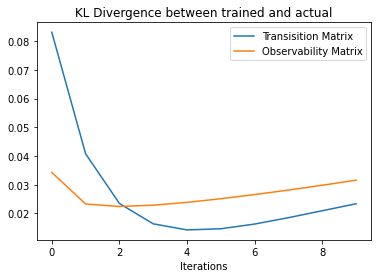

In [38]:
plt.plot(KLA)
plt.plot(KLB)
plt.legend(['Transisition Matrix', 'Observability Matrix'])
plt.title('KL Divergence between trained and actual')
plt.xlabel('Iterations')
plt.show()